In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from process import process

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv("../data/train.csv")

In [4]:
import math

In [16]:
def TheilWageSmoothing(ts, params, h=1):
    """
    Get predictions for timeseries using Theil-Wage model
    
    :ts - time series
    :params - dict with keys: "alpha", "beta", "gamma", "season"
    :h - horison
    
    Return
    :y_pred - predictions, size n + h (n - size of time series)
    :l - forecast parameter without trend and seasonality, size n
    :b - trend component, size n
    :s - seasonal component, size n
    """
    T = len(ts)
    x = ts.copy()
    x.index = np.arange(T)
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    p = params['season']
    
    y_pred = [np.NaN]*(T+h)
    
    l = [np.NaN] * T
    l[0] = x[0]
    b = [np.NaN] * T
    b[0] = 0
    s = [np.NaN] * (T + p)
    for i in range(p):
        if i < T:
            s[i] = x[i]
        else:
            s[i] = s[i-1]

    for i in range(T):
        if not math.isnan(x[i]):
            if i < p and i > 0:
                l[i] = alpha * (x[i] - s[i]) + (1 - alpha) * (l[i-1] + b[i-1])
                b[i] = beta * (l[i] - l[i-1]) + (1 - beta) * b[i-1]
                y_pred[i+h] = l[i] + b[i] + s[i]
            elif i >= p and i > 0:
                s_old = s[i - p]
                l[i] = alpha * (x[i] - s_old) + (1 - alpha) * (l[i-1] + b[i-1])
                b[i] = beta * (l[i] - l[i-1]) + (1 - beta) * b[i-1]
                s[i] = gamma * (x[i] - l[i]) + (1 - gamma) * s[i - p]
                y_pred[i+h] = l[i] + b[i] + s[i + h%p - p]
                
    return y_pred, l[:T], b[:T], s[:T]

In [94]:
def get_stat(N_times=10):
    data = raw_data.loc[:, ('demand', 'product_rk', 'store_location_rk', 'period_start_dt')]

    # N_times = 10
    counter = 0

    for prod in data.product_rk.unique():
        for store in data.store_location_rk.unique():
            X_curr = data[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna()]
            if X_curr.shape[0] == 0:
                continue
            params = {"alpha": 0.2, "beta": 0.01, "gamma": 0.5, "season": 52}
            h = 52
            n = X_curr.demand.shape[0]
            y_hat, l, b, s = TheilWageSmoothing(X_curr.demand, params, h=h)

            X_curr["period_start_dt"] = pd.to_datetime(X_curr["period_start_dt"], format='%Y.%m.%d')

            ts_pred = pd.date_range(X_curr["period_start_dt"].min(), periods=len(y_hat), freq='W')
            d = {'period_start_dt': ts_pred, 'y': y_hat}
            predictions = pd.DataFrame(data=d)

            dt_start = datetime(2020, 11, 1)
            dt_end = datetime(2020, 11, 30)
            nov_2020_pred = predictions[(predictions['period_start_dt'] >= dt_start) &
                                        (predictions['period_start_dt'] <= dt_end)]["y"]
            peak1 = predictions[(predictions['period_start_dt'] >= dt_start) &
                                        (predictions['period_start_dt'] <= dt_end)]
            peak1 = peak1[peak1.y == peak1.y.max()]

            dt_start = datetime(2019, 11, 1)
            dt_end = datetime(2019, 11, 30)
            nov_2019 = X_curr[(X_curr['period_start_dt'] >= dt_start) & 
                              (X_curr['period_start_dt'] <= dt_end)]["demand"]
            peak2 = X_curr[(X_curr['period_start_dt'] >= dt_start) & 
                              (X_curr['period_start_dt'] <= dt_end)]
            peak2 = peak2[peak2.demand == peak2.demand.max()]

            if nov_2019.max() > 0 and nov_2020_pred.max() / nov_2019.max() >= N_times:
                plt.axvline(x=peak2.period_start_dt.max(), color='k', linestyle='--')
                plt.axvline(x=peak1.period_start_dt.max(), color='r', linestyle='--')
                plt.axhline(y=peak2.demand.max(), color='k', linestyle='--')
                plt.axhline(y=peak1.y.max(), color='r', linestyle='--')
                plt.plot(X_curr.period_start_dt, X_curr.demand, label="Факт")
                plt.plot(predictions.period_start_dt, predictions.y, label="Предсказание")
                plt.legend()
                plt.show()
    #             print(nov_2020_pred.max() / nov_2019.max())
                counter += 1
            if nov_2020_pred.max() > 0 and nov_2019.max() / nov_2020_pred.max() >= N_times:
                counter += 1
    return counter

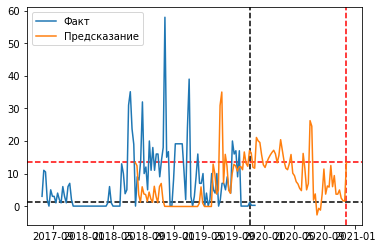

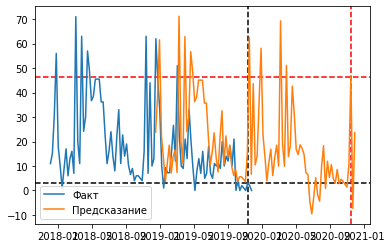

2

In [96]:
get_stat(10)

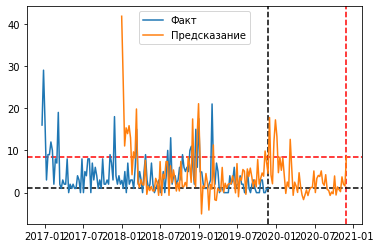

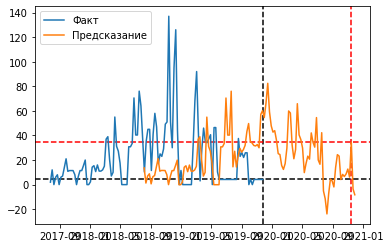

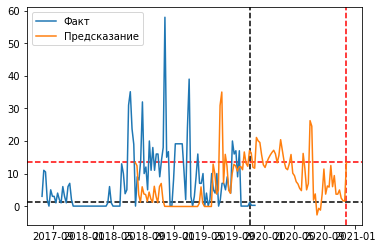

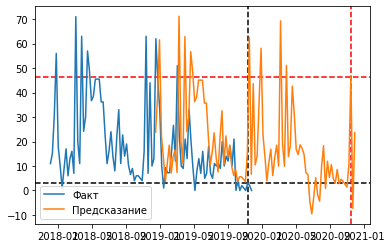

4

In [97]:
get_stat(8)

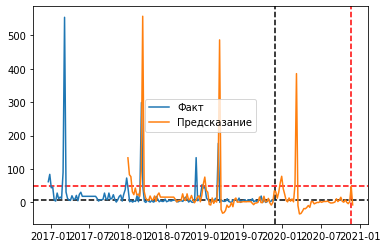

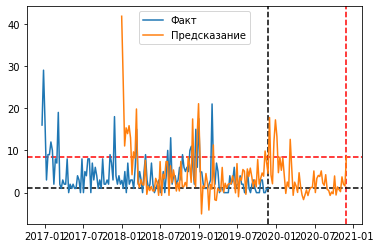

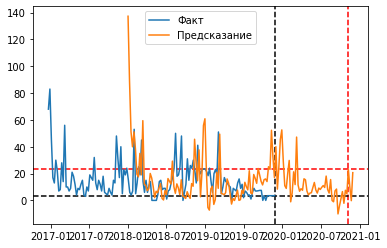

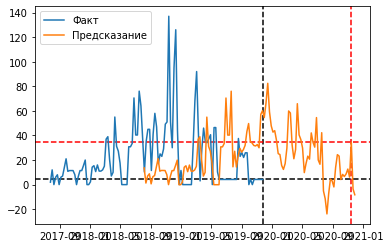

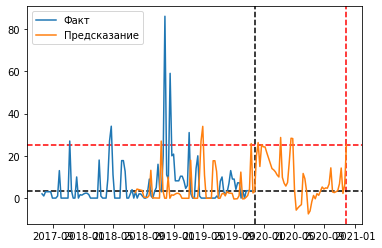

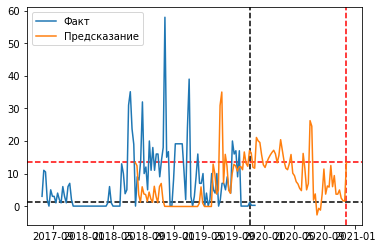

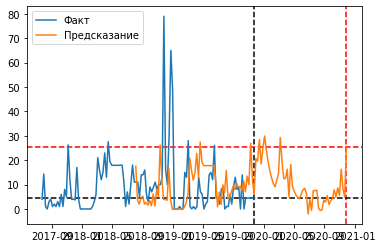

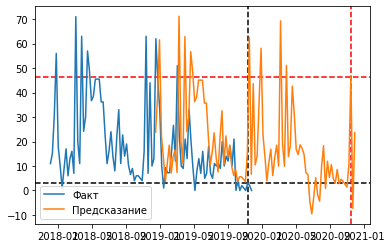

8

In [98]:
get_stat(5)